# Skills showed in this Notebook
The analysis covers missing handling, data manipulation, computation and visualization, dimensionality reduction techniques, appliying unsupervised learning algorithms, and hyperparameter tuning,in order to find the ten best regions in Russia to launch a wine promotion.

This analysis is based in Python  
✅ Data manipulation : Numpy and Pandas  
✅ Data Visualization : Seaborn and Matplotlib  
✅ Unsupervised learning Techniques : Sklearn 



# Where should a drinks company run promotions?
#### 📖 Background
Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

#### 💪 Competition challenge

1. Recommend 10 additional regions they should select for the promotion.
2. Tell the story that supports your recommendations



In [1]:
%%capture
#Neccesaries librarys
!pip install missingno

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

#functions 
from missingno import matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
df['year'] = pd.to_datetime(df.year , format = '%Y')
df['region'] = df.region.astype('category')
df.head()

drinks = ['wine' , 'beer' , 'vodka' , 'champagne', 'brandy']

#### 1. ** Executive summary **
According to Wine intelligencia, the Russian wine market has experienced rampant growth at a 13% compound year rate since 2015. Also, the value spending on wine increases a 20.9% compound year rate over the same period. In conclusion, not only Russians are buying more wine but they are spending more on it so it is a great opportunity for wine retail to catch on to the wave and expand their sales.
Using a data set that contains the evolution of per capita average alcohol consumption through the time for several regions in Russia, our goal is to develop a cluster analysis that allows us to see which regions are the followings to be expanded.
To address this issue, first I develop a way to summarize the evolution of alcohol consumption through time. Then, I scale the data in order to improve the model performance. Afterward, I apply a Principal Component Analysis which is a technique that allows us to reduce the dimensionality of the data and avoid the curse of high dimension that suffers clustering techniques as K-means. Next, I run a K-means model with 4 clusters, as an elbow analysis suggested.
Finally, I find that the ten regions similar to Saint Petersburg that the company might run the promotion are:
Tver Oblast, Sverdlovsk Oblast, Kaliningrad Oblast, Yaroslavl Oblast, Chukotka Autonomous Okrug, Pskov Oblast, Primorsky Krai, Republic of Karelia, Kaluga Oblast and Novgorod Oblast.

#### 2. **Bussines Problem and motivation**
Promotions are expensive, so is hight necessary to run them in better places. To maximize the likelihood of success one should use the best approach to select them.
In this notebook, I should address the question about in which regions of Russia the company should run a promotion since that it has already developed a successful promotion in Saint Petersburg?



#### 3. **Picking a quick glance and handling missing data**

In [4]:
#check for missing values and data types.
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   year       1615 non-null   datetime64[ns]
 1   region     1615 non-null   category      
 2   wine       1552 non-null   float64       
 3   beer       1557 non-null   float64       
 4   vodka      1554 non-null   float64       
 5   champagne  1552 non-null   float64       
 6   brandy     1549 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(5)
memory usage: 80.1 KB


,count,mean,std,min,25%,50%,75%,max
wine,1552.0,5.628144,2.813208,0.10,3.575,5.40,7.3775,18.10
beer,1557.0,51.260148,25.372821,0.40,32.400,49.97,67.4000,207.30
vodka,1554.0,11.818694,5.128806,0.05,8.300,11.50,15.0000,40.60
champagne,1552.0,1.313177,0.797956,0.10,0.800,1.20,1.6650,5.56
brandy,1549.0,0.526998,0.400201,0.00,0.200,0.40,0.7000,2.30


Chechen Republic          19
Sevastopol                16
Republic of Crimea        16
Republic of Ingushetia    15
Altai Krai                 0
                          ..
Kurgan Oblast              0
Krasnoyarsk Krai           0
Krasnodar Krai             0
Kostroma Oblast            0
Zabaykalsky Krai           0
Name: region, Length: 85, dtype: int64 Altai Krai                  19
Republic of Karelia         19
Sakha (Yakutia) Republic    19
Saint Petersburg            19
Ryazan Oblast               19
                            ..
Kurgan Oblast               19
Krasnoyarsk Krai            19
Krasnodar Krai              19
Kostroma Oblast             19
Zabaykalsky Krai            19
Name: region, Length: 85, dtype: int64


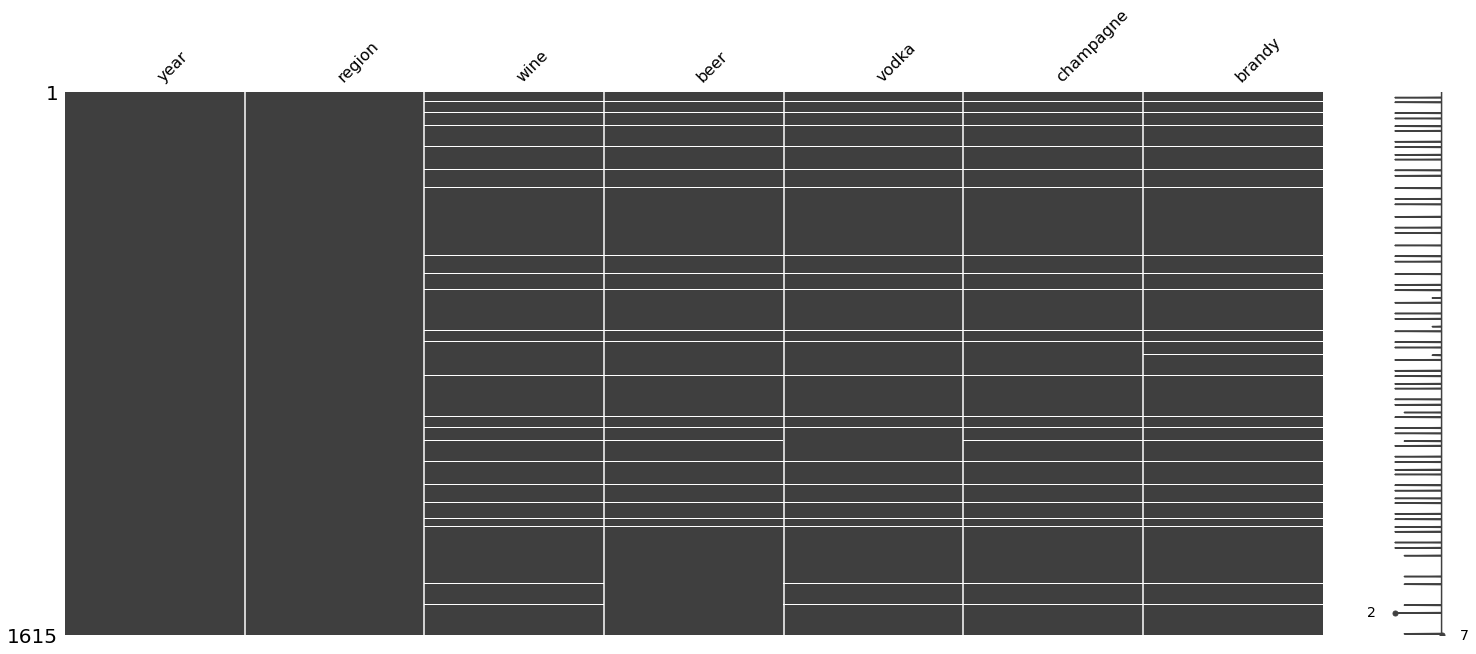

In [5]:
#Handling missing data 
matrix(df)
#¿there are from a particular region?
missing_df = df[df.isna().any(axis=1)]
print(missing_df.region.value_counts() , df.region.value_counts())

Regarding missing values, there exist 4 problematics regions in the dataset Chechen Republic, Sevastopol, Republic of Crimea, and the Republic of Crimea, all of them have so few observations and will be removed. The conclusion of this research are conditionals to I am not considerating these regions because of the lack of data.



In [6]:
#Removing problematic regions
bad_region = list(missing_df.region.unique())
filter = df.region.isin(bad_region)
df = df[~filter]

#### 3.Exploratory data analisys

First I will look for the data distribution and its development through time and comparing with Saint Petersburg data.

In [7]:
sp_df = df[df.region == 'Saint Petersburg']
nsp_df = df[df.region != 'Saint Petersburg']

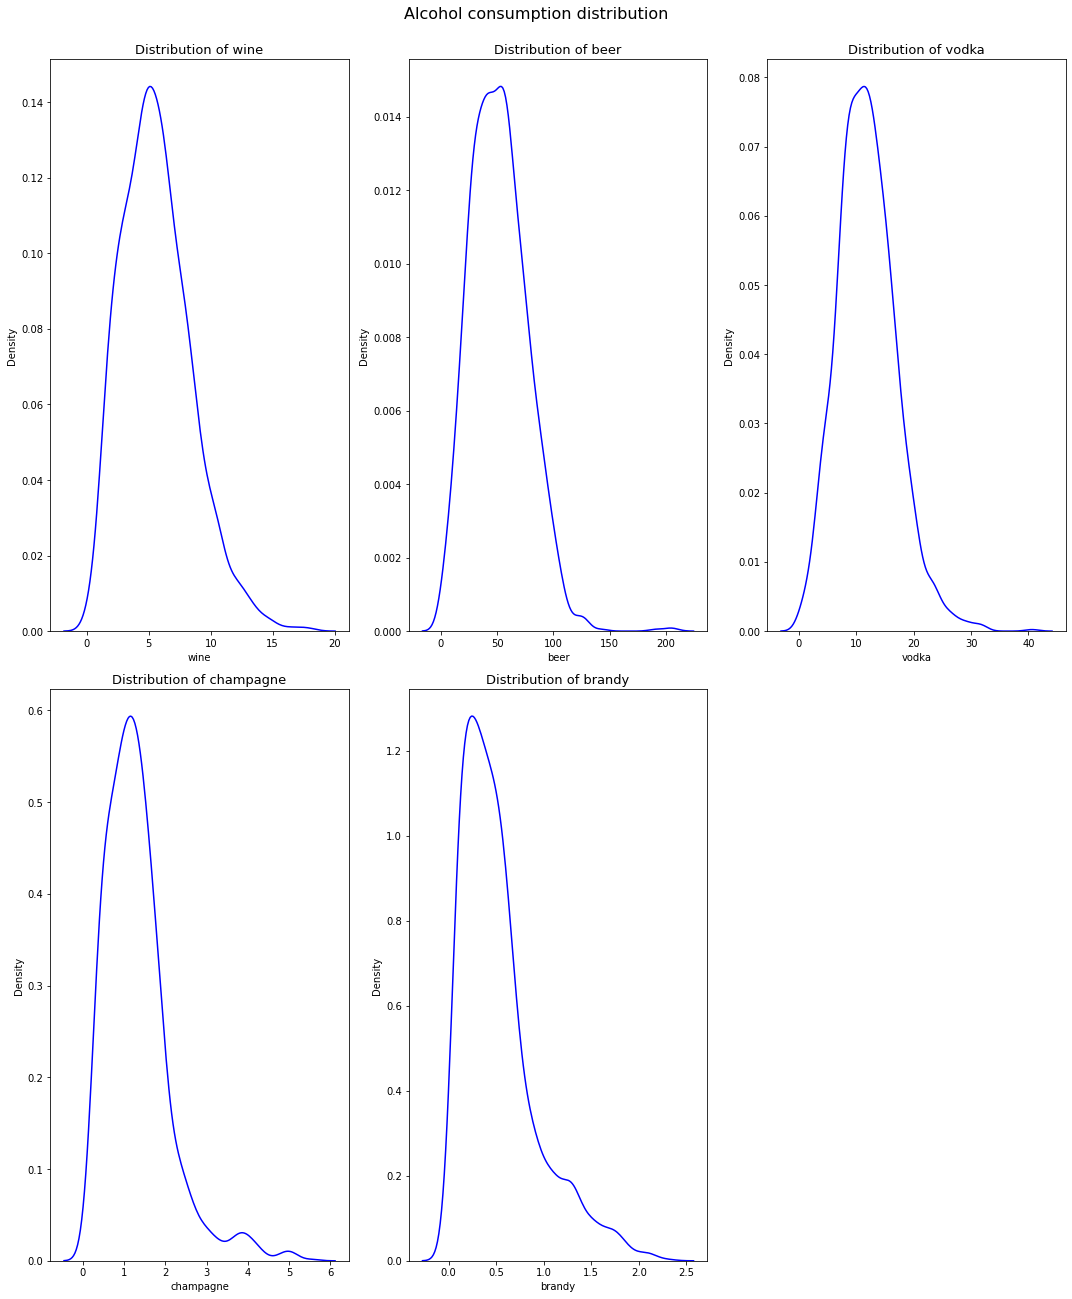

In [8]:
#Looking for distributions 
fig = plt.figure(figsize=(15, 18))
for i, col in enumerate(drinks):
    # Plot lineplot 
    plt.subplot(2,3,i+1); sns.kdeplot(df[col], color='blue');
    plt.title(f'Distribution of {col}', fontsize=13)
fig.suptitle('Alcohol consumption distribution',y=1, fontsize=16)
plt.tight_layout()

All the distributions display a bell shape, which is a good characteristic. Anyway, for further analysis, it would be better if a logarithmic transformation is made. It wouldn't change the characteristics of our data but it will improve the performance of the predictive model.

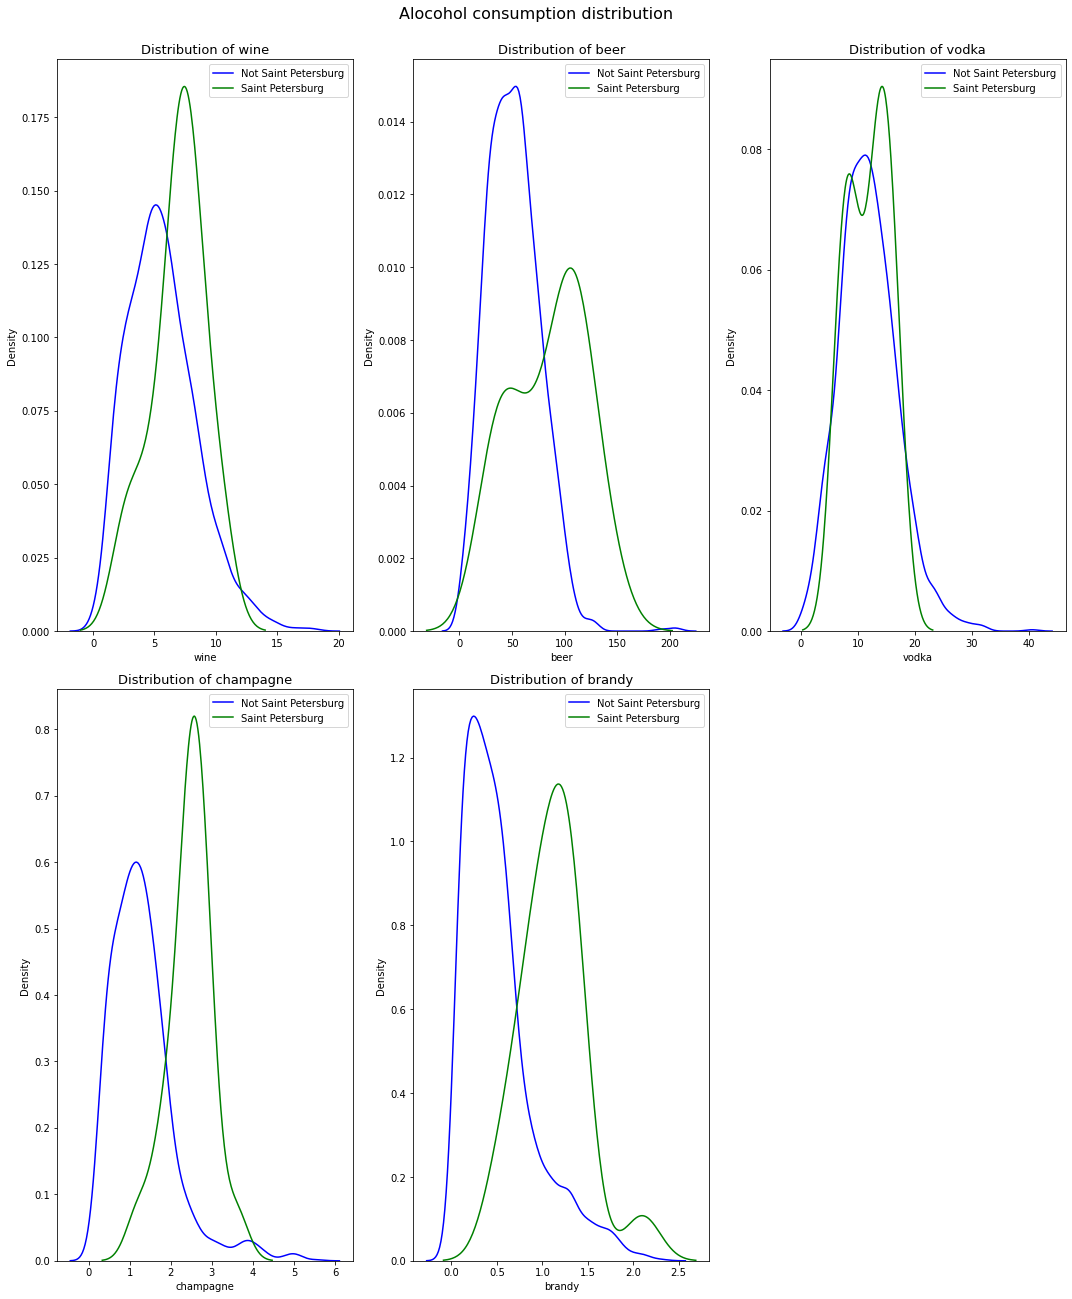

In [9]:
fig = plt.figure(figsize=(15, 18))
for i, col in enumerate(drinks):
    # Plot lineplot 
    plt.subplot(2,3,i+1); sns.kdeplot(nsp_df[col], color='blue' , label = 'Not Saint Petersburg') 
    sns.kdeplot(sp_df[col], color = 'green' , label = 'Saint Petersburg')
    plt.title(f'Distribution of {col}', fontsize=13)
    plt.legend()
fig.suptitle('Alocohol consumption distribution',y=1, fontsize=16)
plt.tight_layout()

All Saint Petersburg distributions (green)  are to the right of the data which doesn't include Saint Petersburg(blue), it seems that on average the consumption of alcohol in Saint Petersburg is greater than in the overall data.
Let's look at the evolution of alcohol consumption through time

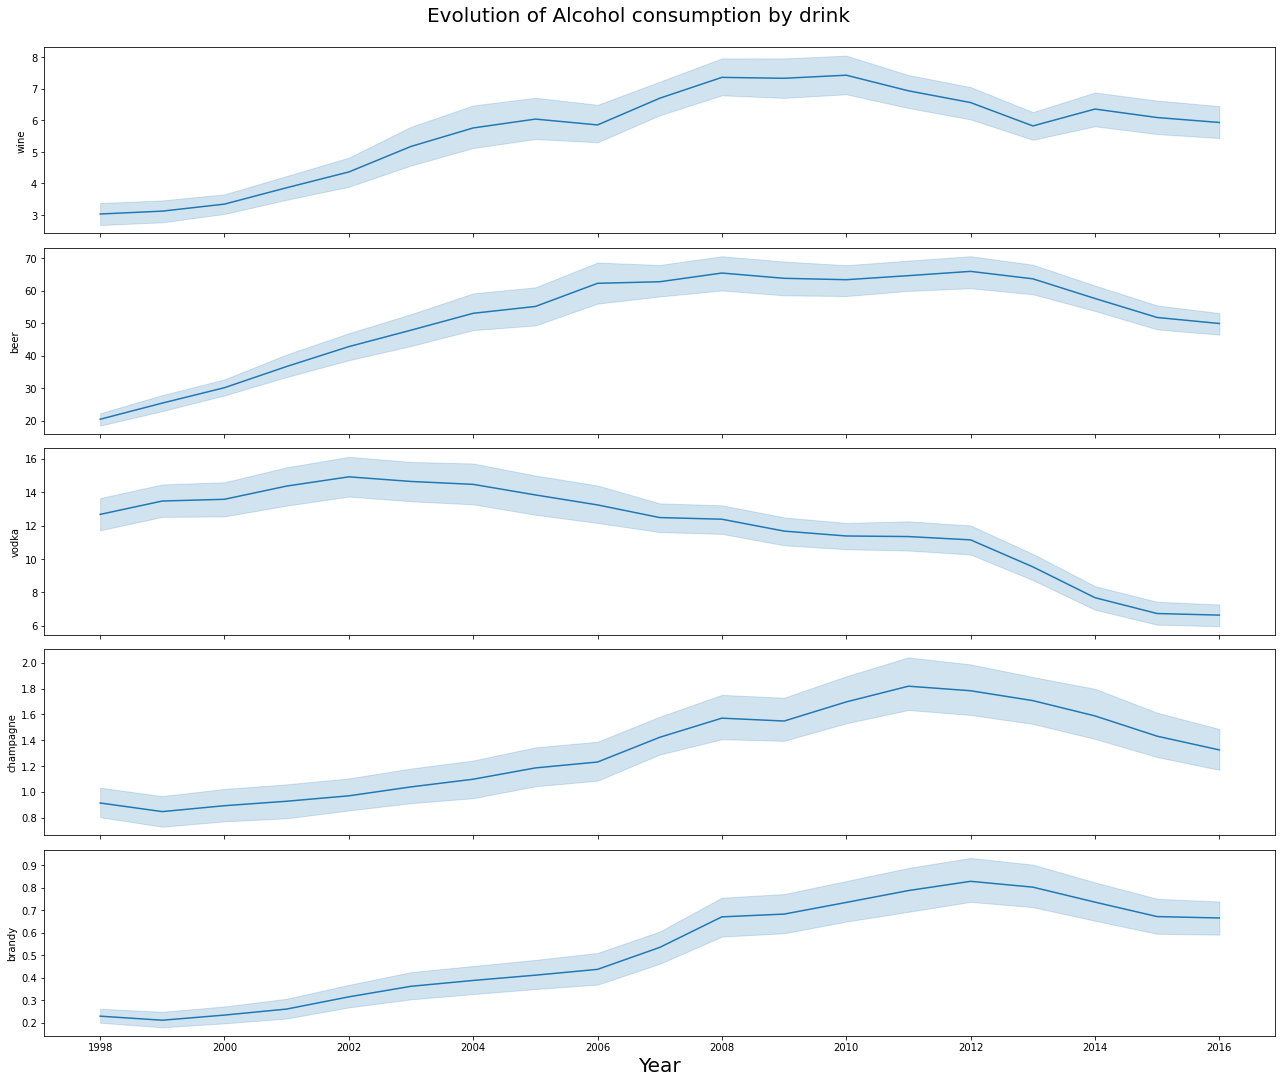

In [10]:
#Evolution Around the time all data set
fig, axs = plt.subplots(5,1,figsize=(18,15),sharex=True)
fig.suptitle('Evolution of Alcohol consumption by drink', y=1 , fontsize = 20)
for i, col in enumerate(drinks):
    sns.lineplot(x='year', y= col , data = df, ax = axs[i])
axs[4].set_xlabel('Year', fontsize=20)
plt.tight_layout()
    

Second I am going to look at the evolution through the time of Saint Petersburg and the other regions for separate

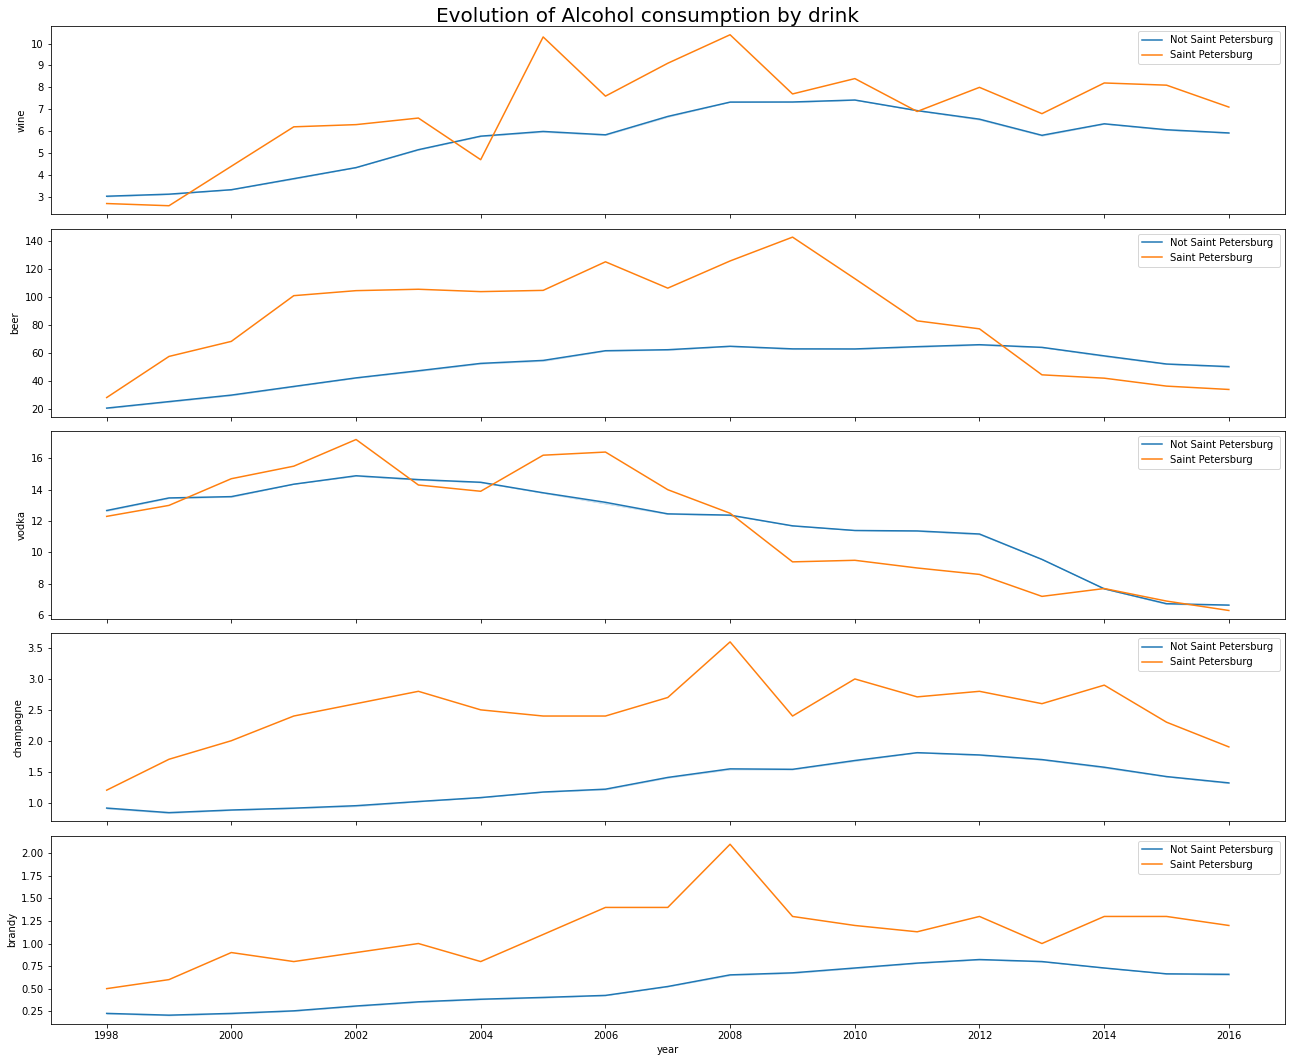

In [11]:
%%capture --no-display
#Evolution Around the time Saint Petersburg and Not Saint Petersburg data
fig, axs = plt.subplots(5,1,figsize=(18,15),sharex=True)
fig.suptitle('Evolution of Alcohol consumption by drink' , fontsize = 20)
for i, col in enumerate(drinks):
    sns.lineplot(x='year', y= col , data = nsp_df, ax = axs[i] , label = 'Not Saint Petersburg ' \
                 , ci = False)
    sns.lineplot(x='year', y= col , data = sp_df, ax = axs[i], label = 'Saint Petersburg' , ci = False)
    plt.legend()
plt.tight_layout()
    

Although, as we have seen before, the average alcohol consumption of Saint Petersburg is above the average alcohol consumption which does not include Saint Petersburg data, both data set show a similar trend.

Finally, I run a correlation of alcoholic drink consumptions, for the entire data set, non-Saint Petersburg data set, and Saint Petersburg data set.

In [12]:
def mult_correlation_matrix(df1, df2, df3, data_set =['']*3):
    # Set up the matplotlib figure
    fig, axs = plt.subplots(1,3,figsize=(15, 20))                    # Set figure size
    l = [df1 , df2, df3]
    for i,df in enumerate(l):
        #Compute the correlation matrix
        corr = df.corr(method = 'pearson')

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))

    
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        cbar_ax = fig.add_axes([.9, .4, .03, .2])
        # Draw the heatmap with the mask 
        sns.heatmap(corr, 
                mask = mask, 
                cmap = cmap, 
                vmax = 1,                                      # Set scale min value
                vmin = -1,                                     # Set scale min value
                center = 0,                                    # Set scale min value
                square = True,                                 # Ensure perfect squares
                linewidths = 1.5,                              # Set linewidth between squares
                cbar_kws = {"shrink": .9},                     # Set size of color bar
                annot = True ,                                  # Include values within squares
                ax = axs[i],
                cbar_ax = cbar_ax 
                    
               );
        axs[i].tick_params(labelrotation=45)   # Rotate y labels
        axs[i].set_title(f'{data_set[i]}', y=1.05, fontsize =15);   # Set plot title and positionnsp_df.corr()
    fig.suptitle('Correlation Matrix', x=0.5 , y=0.64, fontsize = 20)


                               
    # plt.xlabel('X Axis Title', size=20)                      # Set x axis title
    # plt.ylabel('Y Axis Title', size=20)                      # Set y axis title


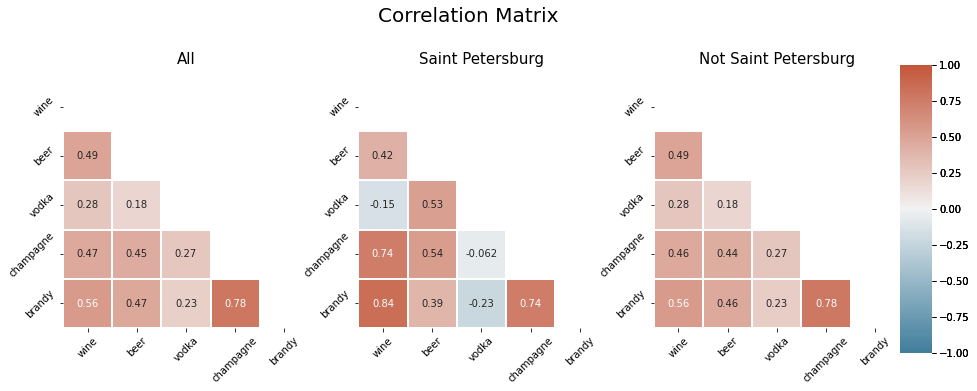

In [13]:
#Looking for correlation matrix
mult_correlation_matrix(df, sp_df, nsp_df , ['All', 'Saint Petersburg' , 'Not Saint Petersburg'])

Comparing the Saints Peterburg data set with the two others is possible to see that Wine consumption is strongly correlated with Brandy and Champagne consumption, which means that Wine, Champagne, and Beer tend to move in the same ways. This trend could be seen in Beer consumption but it is weaklier, and, also weakly than the correlation observe in the other data set. Finally, we can see that Vodka consumption is negatively correlated with Wine consumption, however, that effect is too weak.
A good cluster analysis should recommend regions where not only the consumption per capita was similar but also the correlations.



#### 4.**Data Set**
The data set is known as Data Panel, which means that you have information for a region through time.  Making a cluster analysis is difficult because there isn't a clear way to cluster regions that share similar trends through time.

If we do not consider that we aren't working with a Data Panel, we could probably end in the conclusion that the best region to launch a commercial campaign apart from Saint Peterburg in 2021 is Saint Petersburg in 2016 or Altai Krai in 2005. Although if I only pick last year's information I will be ignoring too much information about the past for the regions.

So to tackle this issue, I choose to use the six last years of the Data Set because, if I only kept the last year and use a clustering method as KNN, there it would be too sensitive to outliers. For example, if Altai Krai is very similar to Saint Petersburg but in 2016 it experienced a short in wine consuming then the algorithm will show that is a different region just for an atypical observation.
Also, I am not including the complete Data set because I am looking for regions similar to Saint Petersburg now, and if I use a gap of 16 years between 1998 to 2016 I will be using too old information.
So the procedure to data that I propose is :
1) Use the mean consumption of Wine, Beer, Vodka, Champagne, and Brandy between the years 2010-2016
2) Use the correlation between Wine and the other drinks between 2010-2016 
3) Use the 'trend' of wine consumption for every region, defining it as the coefficient $$ (\frac{Wine \space Consumption \space 2016}{Wine \space Consumption \space 2010}\\) $$

The result would be a data set that contains one row per region summarizing the alcohol consumption of each.

In [14]:
df_5 = df.copy()
df_5 = df_5.loc[df_5.year >= '2010-01-01']

In [15]:
df_5_corr = df_5.groupby('region').corr()['wine'].T.unstack().drop(columns = 'wine')
df_5_corr

,beer,vodka,champagne,brandy
region,,,,
Altai Krai,-0.039845,0.073095,-0.132210,0.035548
Altai Republic,0.683169,0.663124,-0.031259,0.562694
Amur Oblast,0.567191,0.395589,0.115989,0.442995
Arkhangelsk Oblast,-0.385053,0.789181,0.768277,0.791038
Astrakhan Oblast,0.254728,0.412599,0.151128,-0.458320
...,...,...,...,...
Vologda Oblast,0.430761,0.603253,0.188507,0.100259
Voronezh Oblast,0.824537,0.787070,0.850945,0.042779
Yamalo-Nenets Autonomous Okrug,0.546515,0.811201,0.468799,0.267708


In [16]:
df_5_mean=df_5.groupby('region').mean()

In [17]:
#Creating trend variable
df_5_trend= df_5.sort_values(['region', 'year'])
df_5_trend['w_2010'] =df_5_trend['wine'].shift(6)   #I can use this way because all regions have the same numbers of observation
df_5_trend['trend'] = df_5_trend['wine']/df_5_trend['w_2010']   
df_5_trend = df_5_trend.loc[df_5_trend.year == '2016-01-01', ['region' , 'trend']]

In [18]:
#Merging Data sets
df_5_c_m = pd.merge(df_5_corr, df_5_mean , on='region' , suffixes = ('_corr' ,'_mean'))
df_5_c_m_t = pd.merge(df_5_c_m , df_5_trend, on ='region')
df_complete = df_5_c_m_t.set_index('region')

#### 5.Preproccesing 

Now that we have the Data Set with one row per region, we can prepare the data to apply clustering methods. That would take to apply a log transformation to address highly skewed data issues and apply a scaler method, to center and rescale the variables. This will improve the performance of our clustering method.

In [19]:
#Def log transformation.
def to_log(df , log_cols):
    #apply a log transformation tu a numeric colum
    X = df.copy()
    for col in log_cols:
        X[col] =np.log(X[col] + 1) #Add 1 just to avoid Log(0) that it is not define.
    return X 

        

In [20]:
#Applying log transformation
df_c_l = to_log(df_complete , df_complete.columns)

In [21]:
#Applying Standard scaler
X = df_c_l
scaler = StandardScaler()
X_e =scaler.fit_transform(X)
df_x_e = pd.DataFrame(data = X_e , index = X.index , columns = X.columns)

#### 5.**Reducing dimensionality - PCA analysis**
Now I apply a Principal Component Analysis(PCA), which is a technique to address dimensionality reduction and also remove multi-collinearity at the same time. In short, it transforms the data in a way that could express most of the variance, with the fewer variables possible in an attempt to avoid the curse of dimensionality

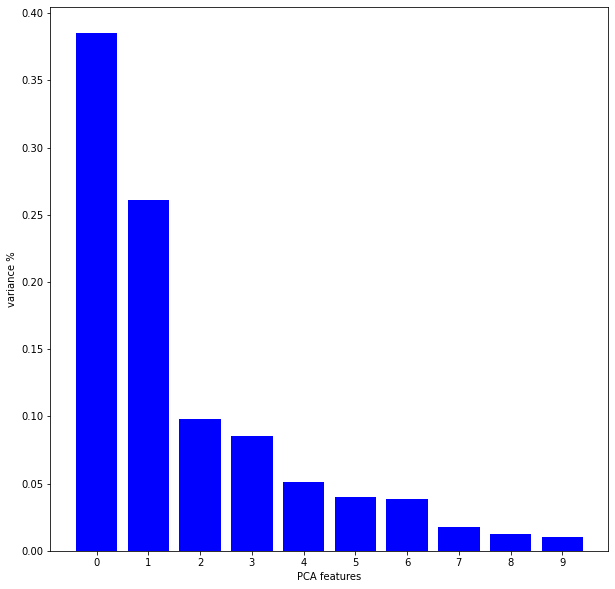

In [22]:
#Create a PCA instance:pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(df_x_e)
#Plot the explained variance
plt.figure(figsize = (10,10))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_ , color = 'blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
#Saving components to a Data Frame 
PCA_components = pd.DataFrame(data = principalComponents , index = df_x_e.index)

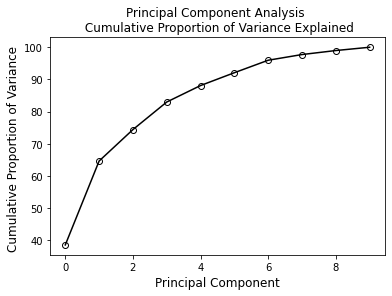

In [23]:
# Assign variance explained
var = pca.explained_variance_ratio_

# Plot cumulative variance
cumulative_var = np.cumsum(var)*100
plt.plot(cumulative_var,'k-o',markerfacecolor='None',markeredgecolor='k')
plt.title('Principal Component Analysis \n Cumulative Proportion of Variance Explained',fontsize=12)
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("Cumulative Proportion of Variance ",fontsize=12)
plt.show()

From the plot above, we see that we need approximately 6 features to explain 90% of the variance. However, if we want to reduce more the features we can use only 4 features and explain above 80% of the variances. In order to reduce the features needed for the analysis, we will continue with only 4 features. 
Since we only have 81 observations is better to minimize variables in order to not overfit the model.

Text(0, 0.5, 'PCA 2')

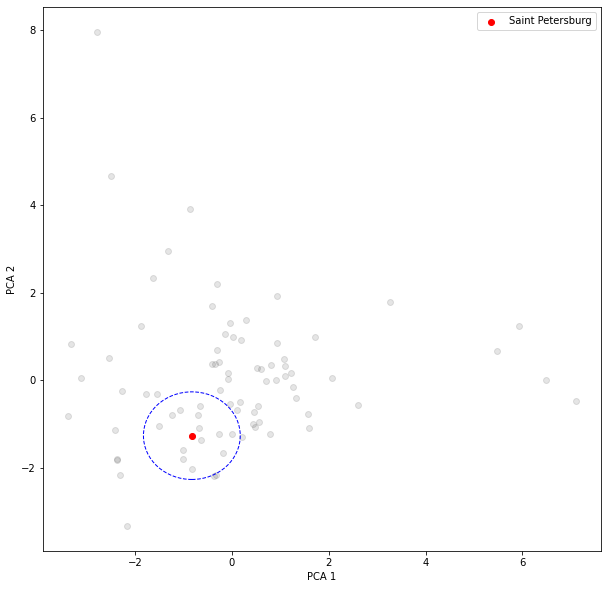

In [24]:
plt.figure(figsize = (10,10))
ax = plt.gca()
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.scatter(PCA_components.loc['Saint Petersburg'][0], 
            PCA_components.loc['Saint Petersburg'][1], 
            color = 'red', label = 'Saint Petersburg')
circle = plt.Circle((PCA_components.loc['Saint Petersburg'][0], 
                      PCA_components.loc['Saint Petersburg'][1]), 
                     1, color='b', 
                     ls = '--',
                     fill=False)
ax.add_patch(circle)
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

It seems that there are very good candidates that are similar to Saint Petersburg. Anyway, here we use just the 2 most important features, instead of 4, so when we add the remaining features we will get a more accurate result.

#### 6.**Clustering**
Clustering refers to a very set of techniques for finding subgroups in a data set. The goal is that the observation within every group were similar to each other. In K-means clustering we look to find K non-overlapping clusters, wherein every group the variation between the cluster members should be small as possible.

One of the problems of this clustering method is to address the question about how many clusters exist?.  Too many clusters should cause overfitting but too little should cause biased conclusions. To answer this question one should do an elbow analysis, in which you should choose the number of clusters that gives a high reduction of the inertia ( inertia is a measure of how coherent is every cluster internally). 


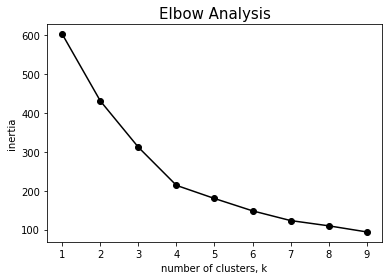

In [25]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title('Elbow Analysis', fontsize = 15)
plt.show()

Looking at the elbow analysis, we should conclude that using 4 or 5 clusters would be okay, additional clusters don't reduce the inertia too much.

In [26]:
#Run Kmeans model with 4 cluster
km = KMeans(n_clusters=4) 
km.fit(PCA_components.iloc[:,:3])
centers = km.cluster_centers_
label = km.predict(PCA_components.iloc[:,:3])
PCA_components['label'] = label
sp_label = PCA_components.loc['Saint Petersburg','label']

Text(0, 0.5, 'PCA 2')

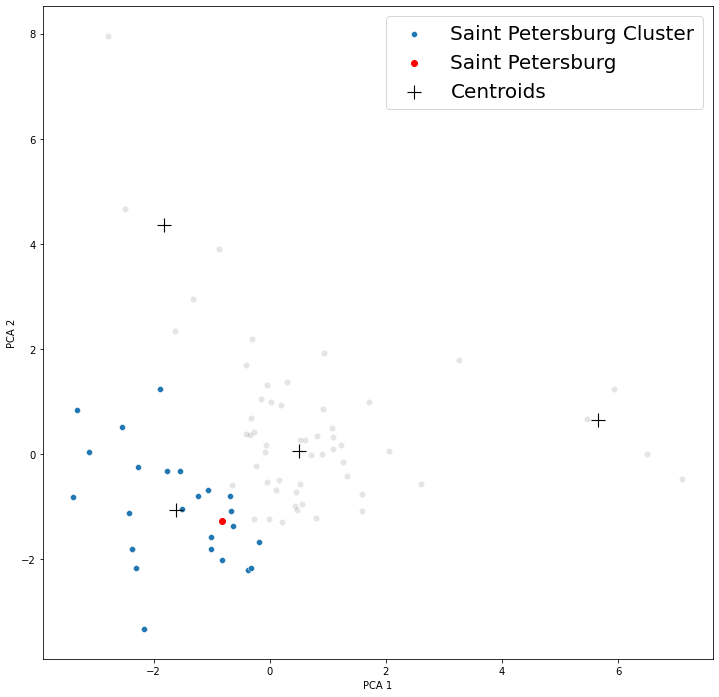

In [27]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=0, y= 1 , 
                data = PCA_components,
                alpha = 0.1,
                color = 'black')
sns.scatterplot(x=PCA_components.loc[PCA_components.label==sp_label][0],
                y=PCA_components.loc[PCA_components.label==sp_label][1], 
               label = 'Saint Petersburg Cluster')
plt.scatter(x=PCA_components.loc['Saint Petersburg'][0],
                y=PCA_components.loc['Saint Petersburg'][1],
                color = 'red',
           label = 'Saint Petersburg')
sns.scatterplot(centers[:,0], centers[:,1], 
                marker='+', 
                color='black',
                label ='Centroids',
                s=200);
plt.legend(fontsize=20)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Now that we have the cluster Saint Petersburg with other similar regions, but unfortunately the cluster has more than ten regions. To tackle the objective of this exercise and only pick ten regions, I just select the ten nearest regions to the centroid which belongs to Saint Petersburg.

In [28]:
#Selecting ten nearest region to centroid 
PCA_components['distance'] = km.transform(PCA_components.iloc[:,:3]).mean(axis=1)
Conclusion= PCA_components[PCA_components.label == sp_label].sort_values('distance').drop(['Saint Petersburg']).index[:10]
Conclusion = pd.DataFrame(Conclusion)

#### 7.**Conclusion**

In [29]:
print('---- Most suitable regions to do the wine promotion ---')
Conclusion

---- Most suitable regions to do the wine promotion ---


,region
0,Tver Oblast
1,Sverdlovsk Oblast
2,Kaliningrad Oblast
3,Yaroslavl Oblast
4,Chukotka Autonomous Okrug
5,Pskov Oblast
6,Primorsky Krai
7,Republic of Karelia
8,Kaluga Oblast
9,Novgorod Oblast


#### Apendix 
##### The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita